In [1]:
import os
import sys

import numpy as np

import skimage.io

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
STAGE1_TRAIN = "input/train"
STAGE1_TEST = "input/test"
STAGE1_TRAIN_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TRAIN
STAGE1_TRAIN_MASK_PATTERN = "%s/{}/masks/*.png" % STAGE1_TRAIN
STAGE1_TEST_IMAGE_PATTERN = "%s/{}/images/{}.png" % STAGE1_TEST

In [3]:
def image_ids_in(root_dir, ignore=[]):
    ids = []
    for id in os.listdir(root_dir):
        if id in ignore:
            print('Skipping ID:', id)
        else:
            ids.append(id)
    return ids

In [4]:
train_image_ids = image_ids_in(STAGE1_TRAIN)

In [5]:
test_image_ids = image_ids_in(STAGE1_TEST)

In [6]:
def read_image(image_id, space="rgb", train=True):
    if train:
        image_file = STAGE1_TRAIN_IMAGE_PATTERN.format(image_id, image_id)
    else:
        image_file = STAGE1_TEST_IMAGE_PATTERN.format(image_id, image_id)
    image = skimage.io.imread(image_file)
    # Drop alpha which is not used
    image = image[:, :, :3]
    if space == "hsv":
        image = skimage.color.rgb2hsv(image)
    return image

In [7]:
def read_image_labels(image_id, space="rgb"):
    image = read_image(image_id, space = space)
    mask_file = STAGE1_TRAIN_MASK_PATTERN.format(image_id)
    masks = skimage.io.imread_collection(mask_file).concatenate()    
    height, width, _ = image.shape
    num_masks = masks.shape[0]
    labels = np.zeros((height, width), np.uint16)
    for index in range(0, num_masks):
        labels[masks[index] > 0] = 255 #index + 1
    return image, labels

In [8]:
train_img = []
train_mask = []
test_img = []

In [9]:
for img_id in train_image_ids:
    ti, tm = read_image_labels(img_id)
    train_img.append(ti)
    train_mask.append(tm)

In [10]:
for img_id in test_image_ids:
    ti = read_image(img_id, train=False)
    test_img.append(ti)

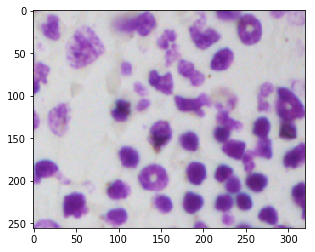

In [11]:
plt.imshow(train_img[53]);

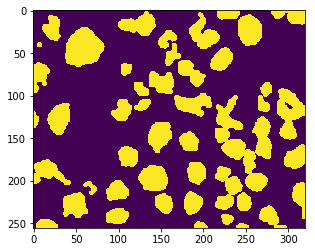

In [12]:
plt.imshow(train_mask[53]);

In [34]:
def hor_flip(img):
    return img[::-1,:,:]

def vert_flip(img):
    return img[:,::-1,:]

def slicer(img):
    shape = np.shape(img)
    
    img_dict = {
        'img': [],
        'vimg': [],
        'himg': [],
        'pos': [],
        'shape': np.shape(img)
    }
    
    if len(shape)==2:
        img = np.reshape(img, (shape[0], shape[1], 1))
        
    x,y,c = np.shape(img)
    
    tx, ty = x//64, y//64
    
    himg = hor_flip(img)
    vimg = vert_flip(img)
    for i in range(0,20*tx):
        sx1 = int(64*(i/20))
        sx2 = int(64*(i/20+1))
        for j in range(0, 20*ty):
            sy1 = int(64*(j/20))
            sy2 = int(64*(j/20+1))
            img_dict['pos'].append([i,j])
            img_dict['vimg'].append(vimg[sx1:sx2, sy1:sy2, :])
            img_dict['himg'].append(himg[sx1:sx2, sy1:sy2, :])
            img_dict['img'].append(img[sx1:sx2, sy1:sy2, :])
    
    return img_dict

In [35]:
simg53 = slicer(train_img[53])
smask53 = slicer(train_mask[53])

In [36]:
def plot_images(images, images_rows, images_cols):
    try:
        f, axarr = plt.subplots(images_rows,images_cols,figsize=(16,images_rows*2))
        for row in range(images_rows):
            for col in range(images_cols):
                image = images[row+images_rows*col]
                height, width, l = image.shape
                ax = axarr[row,col]
                ax.axis('off')
                ax.set_title("%dx%d"%(width, height))
                if image.shape[2]==1:
                    image = np.reshape(image, (image.shape[0], image.shape[1]))
                ax.imshow(image)
    except IndexError:
        pass

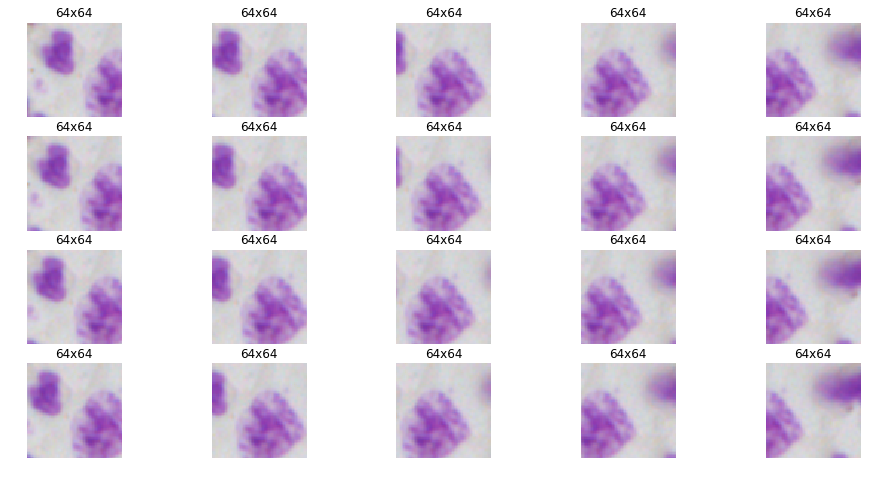

In [37]:
plot_images(simg53['img'], simg53['shape'][0]//64, simg53['shape'][1]//64);

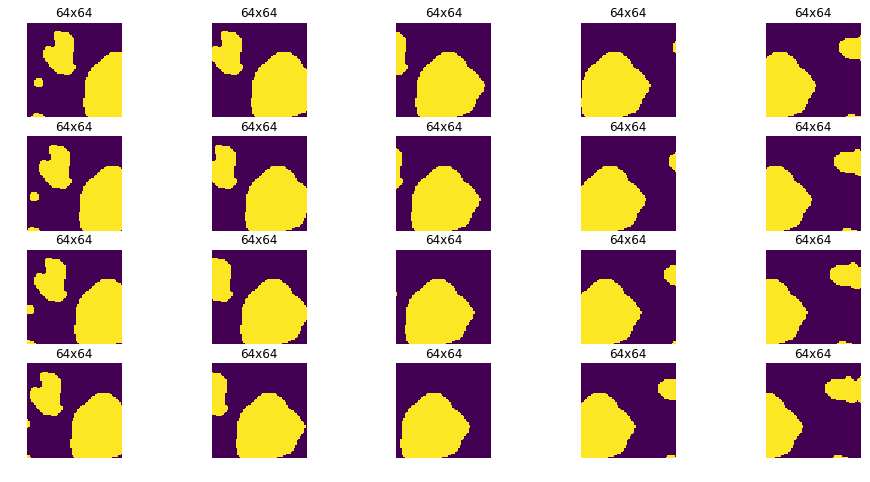

In [38]:
plot_images(smask53['img'], smask53['shape'][0]//64, smask53['shape'][1]//64);

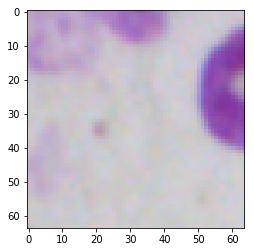

In [39]:
plt.imshow(simg53['vimg'][0]);

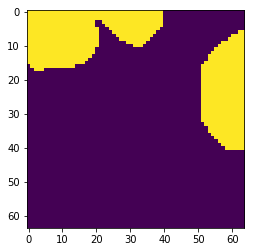

In [40]:
mask53 = np.reshape(smask53['vimg'][0], smask53['vimg'][0].shape[:2])
plt.imshow(mask53);

In [41]:
def concater(imgs, img_shape, imgs_pos):
    if len(img_shape)==2:
        img_shape = [img_shape[0], img_shape[1], 1]
    img = np.zeros(img_shape)
    for pimg, (i, j) in zip(imgs, imgs_pos):
        sx1 = int(64*(i/20))
        sx2 = int(64*(i/20+1))
        sy1 = int(64*(j/20))
        sy2 = int(64*(j/20+1))
        canva = np.zeros(img_shape)
        canva[sx1:sx2, sy1:sy2, :] = pimg[:, :, :]
        img = np.maximum(img, canva)
    return img

In [42]:
con_img = concater(simg53['img'], simg53['shape'], simg53['pos'])
con_mask = concater(smask53['img'], smask53['shape'], smask53['pos'])

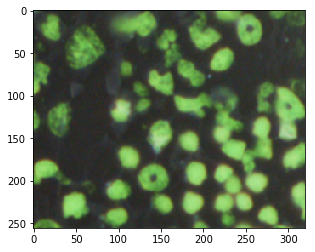

In [43]:
plt.imshow(con_img);

In [44]:
def maximum(img1, img2, img3):
    img = np.maximum(img1, img2)
    img = np.maximum(img, img3)
    return img

def part2all(img_dict):
    imgs = img_dict['img']
    vimgs = img_dict['vimg']
    himgs = img_dict['himg']
    img_shape = img_dict['shape']
    pos = img_dict['pos']
    
    img = concater(imgs, img_shape, pos)
    vimg = concater(vimgs, img_shape, pos)
    himg = concater(himgs, img_shape, pos)
    
    vimg = vert_flip(vimg)
    himg = hor_flip(himg)
    
    img = maximum(img[:, :, :], vimg[:, :, :], himg[:, :, :])
    return img

In [45]:
res_img = part2all(simg53)
res_mask = part2all(smask53)

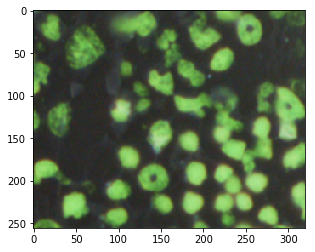

In [46]:
plt.imshow(res_img);

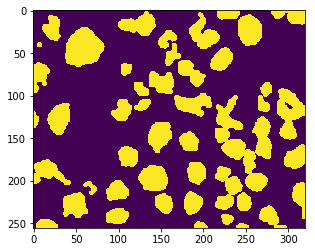

In [47]:
res_mask = np.reshape(res_mask, (res_mask.shape[0], res_mask.shape[1]))
plt.imshow(res_mask);

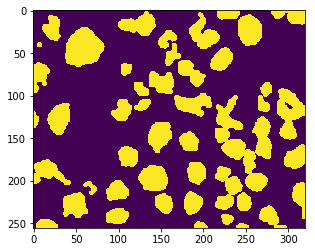

In [48]:
plt.imshow(train_mask[53]);

In [49]:
np.min(np.equal(train_img[53], res_img))

True

In [50]:
np.min(np.equal(train_mask[53], res_mask))

True